## Import libraries

In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy, pickle, os, time
import zipfile as zf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import seaborn as sns
import cv2
import numpy as np
import glob
import csv

## Load the Covid Chestxray-Dataset in the notebook¶

In [3]:
files = zf.ZipFile("data_upload_v3.zip", 'r')
files.extractall('directory to extract')
files.close()
dataset_path='./directory to extract/data'
data_dir = dataset_path

## We have three objectives:¶
Apply augumentation to create transformed version of COVID-19 images (such as flipping, small rotation, adding small amount of distortions), to increase the number of samples by a factor of 5.

Fine-tune the last layer of the pre-trained version of these models on ImageNet. In this way, the model can be trained with less labeled samples from each class. Because it is relatively rare to have a dataset of sufficient size, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

Comparison of two resnet models of resnet 18 and resnet 50

Create an application to ease the procedures for users

## Exploratory data analysis (EDA)¶
We have 3100 images in our test dataset in Covid-Chestxray-Dataset, 3000 cases are non-covid and 100 cases are images labled as covid cases.

We also have 2084 images in our train dataset. Out of 2084 images, 2000 images are labeled as non-covid cases and the rest 84 cases are covid cases. After augmentation we have 420 cases of covid cases.

In our validation dataset, there are 100 cases of covid images and

In [4]:
# Make a dictionary containing both train and validation data

start_time= time.time()
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomResizedCrop(224), # crop the image randomely
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224), # crop the (224*224) image from centre
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x))
                  for x in ['train', 'val']}


## Build the dataset and applying augumentation

In [5]:
# A technique to increase the diversity of your training set by applying random transformations.

start_time= time.time()
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomResizedCrop(224), # crop the image randomely
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224), # crop the (224*224) image from centre
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= 20,
                                             shuffle=True, num_workers= 0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes  ## 0: child, and 1: nonchild


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Undrestanding the data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import data
metadata_dir = 'metadata.csv'
metadata = pd.read_csv(metadata_dir)
# what info do we have?
print(metadata.columns)

Index(['patientid', 'offset', 'sex', 'age', 'finding', 'RT_PCR_positive',
       'survival', 'intubated', 'intubation_present', 'went_icu', 'in_icu',
       'needed_supplemental_O2', 'extubated', 'temperature', 'pO2_saturation',
       'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'view',
       'modality', 'date', 'location', 'folder', 'filename', 'doi', 'url',
       'license', 'clinical_notes', 'other_notes', 'Unnamed: 29'],
      dtype='object')


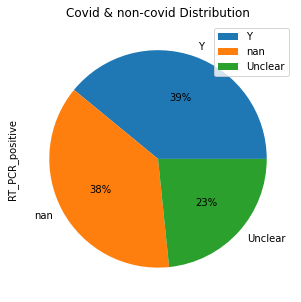

In [7]:
# Let's analyze the distribution of the target values
#(nan if unknown)

ax = metadata['RT_PCR_positive'].value_counts(dropna=False).plot.pie(y='Y', legend = True, autopct='%2.0f%%', figsize = (5,5), title = 'Covid & non-covid Distribution')

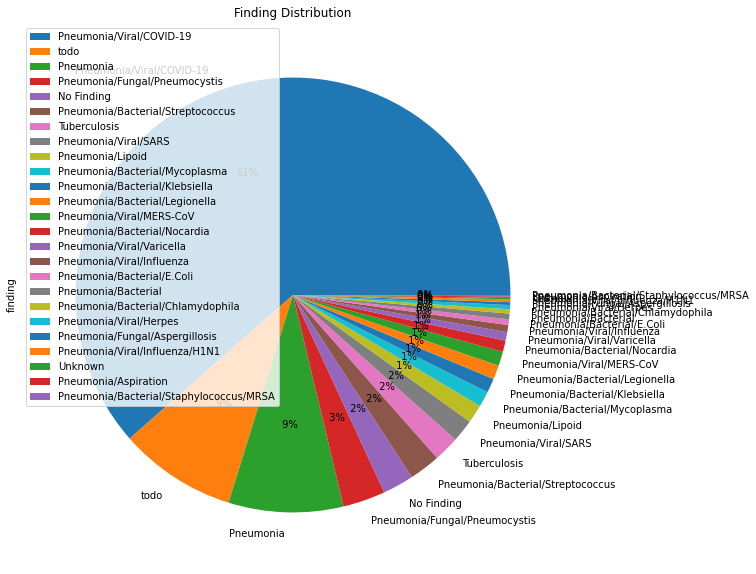

In [8]:
# Finding distribution (nan if unknown)

metadata_dir = 'metadata.csv'
metadata = pd.read_csv(metadata_dir)
ax = metadata['finding'].value_counts(dropna=False).plot.pie(y='Finding', legend = True, autopct='%2.0f%%', figsize = (10,10), title = 'Finding Distribution')

In [9]:
# Load features of dataset and check columns and values
file_df = pd.read_csv('metadata.csv', header=0)
file_df.head()
# check the Whole data size
size_file=file_df.shape
print(size_file)

(950, 30)


## Split the values

In [10]:
# To get each category for each sample in our dataset, we need to split the values in the finding column by space character:
all_cats_df = pd.DataFrame(file_df)

all_cats_df['cats_split'] = all_cats_df['finding'].str.split()

In [11]:
# How many diffrent illness category exist in the finding column?
cats = all_cats_df['cats_split'].sum()
unique_cats = set(cats)
len(unique_cats)

26

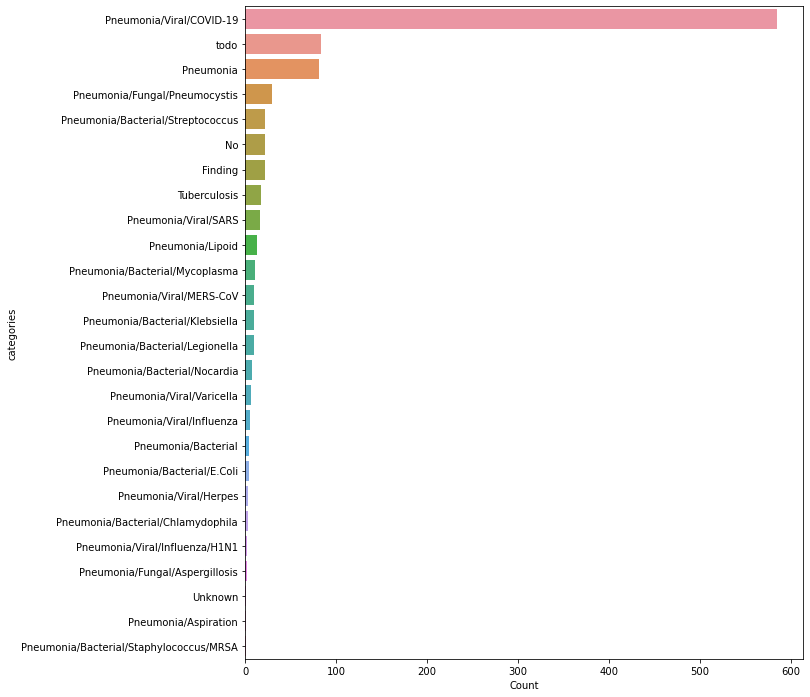

In [12]:
# Now, we look at the distribution of the diffent categories caused desease 
all_cats = nltk.FreqDist(cats) 
all_cats_df = pd.DataFrame({'categories': list(all_cats.keys()), 
                              'Count': list(all_cats.values())})
most_freq_cats = all_cats_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(10,12)) 
ax = sns.barplot(data=most_freq_cats, x= "Count", y = "categories")
plt.show()

In [13]:
## Investigate dataset to check which rows have missing data and check the type of data
file_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   patientid               950 non-null    object 
 1   offset                  697 non-null    float64
 2   sex                     870 non-null    object 
 3   age                     713 non-null    float64
 4   finding                 950 non-null    object 
 5   RT_PCR_positive         593 non-null    object 
 6   survival                361 non-null    object 
 7   intubated               248 non-null    object 
 8   intubation_present      250 non-null    object 
 9   went_icu                397 non-null    object 
 10  in_icu                  335 non-null    object 
 11  needed_supplemental_O2  90 non-null     object 
 12  extubated               37 non-null     object 
 13  temperature             78 non-null     float64
 14  pO2_saturation          119 non-null    fl

In [14]:
## Comparison between this info and size of our dataset show that any row that has less value than 950 includes missing data.
# for example, offset, sex,.... are items which have many missing data.

## Show some of images¶

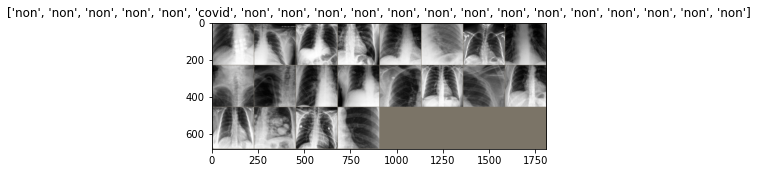

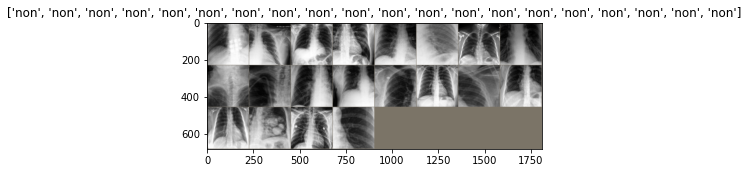

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def imshow(inp,title= None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# call the imshow function defined in above section

imshow(out, title=[class_names[x] for x in classes])
inputs, classes = next(iter(dataloaders['train']))

imshow(out,title=[class_names[x] for x in classes])
inputs, classes = next(iter(dataloaders['val']))

## Show low and high resolution images
There are some low-resolution images in Covid-19 class (below 400 ×400), and some high resolutions ones (more than 1900 ×1400).

In [16]:
image_list = []

for filename in glob.glob(r'C:\Users\Homa\Desktop\sharpest_mind\data_upload_v3\data_upload_v3\test\covid\*.jpg'):    # '*' will count files each by one
    
    #Read
    img = cv2.imread(filename)
    image_list.append(img)

    for x in range(len(image_list)):
        print(image_list[x].shape)
    

(1148, 2563, 3)
(1148, 2563, 3)
(1163, 1165, 3)
(1148, 2563, 3)
(1163, 1165, 3)
(1161, 1170, 3)
(1148, 2563, 3)
(1163, 1165, 3)
(1161, 1170, 3)
(1165, 1165, 3)
(1148, 2563, 3)
(1163, 1165, 3)
(1161, 1170, 3)
(1165, 1165, 3)
(1161, 1166, 3)
(1148, 2563, 3)
(1163, 1165, 3)
(1161, 1170, 3)
(1165, 1165, 3)
(1161, 1166, 3)
(1828, 2200, 3)
(1148, 2563, 3)
(1163, 1165, 3)
(1161, 1170, 3)
(1165, 1165, 3)
(1161, 1166, 3)
(1828, 2200, 3)
(1831, 2200, 3)
(1148, 2563, 3)
(1163, 1165, 3)
(1161, 1170, 3)
(1165, 1165, 3)
(1161, 1166, 3)
(1828, 2200, 3)
(1831, 2200, 3)
(787, 902, 3)
(1148, 2563, 3)
(1163, 1165, 3)
(1161, 1170, 3)
(1165, 1165, 3)
(1161, 1166, 3)
(1828, 2200, 3)
(1831, 2200, 3)
(787, 902, 3)
(806, 834, 3)
(1148, 2563, 3)
(1163, 1165, 3)
(1161, 1170, 3)
(1165, 1165, 3)
(1161, 1166, 3)
(1828, 2200, 3)
(1831, 2200, 3)
(787, 902, 3)
(806, 834, 3)
(762, 894, 3)
(1148, 2563, 3)
(1163, 1165, 3)
(1161, 1170, 3)
(1165, 1165, 3)
(1161, 1166, 3)
(1828, 2200, 3)
(1831, 2200, 3)
(787, 902, 3)
(806, 